# Importing

## Importing modules

In [264]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import time
import random
import math
from multiprocessing import Process, Queue

import keras
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.models import load_model
from keras.optimizers import SGD, adam, adagrad, rmsprop


## importing own code

In [265]:
from generateSpace import *
from plotLattice import *
from getTriangleLengths import *
from potentialEnergyPerTrio import *
from potentialEnergy import *
from potentialEnergyPerParticle import *
from numberOfCalculations import *
from makeRandomDatabase import *
from prepareDatabaseForMachineLearning import*

## Writing own code

In [266]:
def trainNetwork(network, trainingData, validationSplit, numberOfEpochs=50, batchSize=32, verboseSetting=-1):
    """
    hjhgj
    
    network is the Keras network to be trained.
    trainingData is the data to be trained with. It is a tupple with the index zero being the input data and index one being the target/output value.
    validationData is the data used to do validation.  It is a tupple with the index zero being the input data and index one being the target/output value.
    numberOfEpochs is the number of epochs the model will train for default is 50.
    batchSize is the size of the batches during gradiant decent defaul is 32.
    verboseSettings are the verbose settings default is -1 (which does nothing), 0 results in plots and above that normal rules apply.
    """
    
    #print(np.shape(trainingData[0]))
    #print(np.shape(trainingData[0][0]))
    #print(np.shape(trainingData[1]))
    
    #print(trainingData[0])
    
    fitDetails = network.fit(trainingData[0], trainingData[1], shuffle=True, batch_size=batchSize, validation_split=validationSplit, epochs=numberOfEpochs, verbose=max(0,verboseSetting))
    
    history = {'loss': fitDetails.history['loss'], 'val_loss': fitDetails.history['val_loss']}
    
    if verboseSetting>=0:
        
        maximumValue = max(max(history['loss']), max(history['val_loss']))
        minimumValue = min(min(history['loss']), min(history['val_loss'])) / 10#math.pow(math.floor(math.log(min(min(history['loss']), min(history['val_loss'])), 10)) - 1, 10)
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
        ax1.plot([i for i in range(1, numberOfEpochs + 1)], history['loss'], label='Training loss')
        ax1.plot([i for i in range(1, numberOfEpochs + 1)], history['val_loss'], label='Validation loss')
        ax1.legend()
        ax1.set_xlim(1, numberOfEpochs)
        ax1.set_ylim(0, maximumValue)
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.set_title('Loss (training and validation) vs the number of epochs.')
        
        ax2.plot(history['loss'], history['val_loss'])
        ax2.set_xlim(0, maximumValue)
        ax2.set_ylim(0, maximumValue)
        ax2.set_xlabel('Training loss')
        ax2.set_ylabel('Validation loss')
        ax2.set_title('Validation loss vs training loss.')
        
        ax3.plot([i for i in range(1, numberOfEpochs + 1)], history['loss'], label='Training loss')
        ax3.plot([i for i in range(1, numberOfEpochs + 1)], history['val_loss'], label='Validation loss')
        ax3.legend()
        ax3.set_xlim(1, numberOfEpochs)
        ax3.set_yscale('log')
        ax3.set_ylim(minimumValue, maximumValue)
        ax3.set_xlabel('Epochs')
        ax3.set_ylabel('Loss')
        ax3.set_title('Loss (training and validation) vs the number of epochs (logarithmic)')
        
        ax4.plot(history['loss'], history['val_loss'])
        ax4.set_xscale('log')
        ax4.set_xlim(minimumValue, maximumValue)
        ax4.set_yscale('log')
        ax4.set_ylim(minimumValue, maximumValue)
        ax4.set_xlabel('Training loss')
        ax4.set_ylabel('Validation loss')
        ax4.set_title('Validation loss vs training loss (logarithmic).')
        
        math.pow(math.log(min(min(history['loss']), min(history['val_loss'])), 10), 10)
        
        plt.show()
        history['figure'] = [fig, ax1, ax2, ax3, ax4]
    
    return history

In [267]:
def makePredictionPlot(model, dataFrame, amountOfPoints=1000):
    prediction = []
    realValue = []
    
    for i in range(min(len(dataFrame['potentialEnergy']), amountOfPoints)):
        index = dataFrame.index[i]
        prediction.append(model.predict([[dataFrame['eigenvalues'][index]]])[0][0])
        realValue.append(dataFrame['potentialEnergy'][index])
    
    fig, ((ax1)) = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
    ax1.scatter(realValue, prediction, s=5)
    ax1.set_xlim(min(min(prediction), min(realValue)), max(max(prediction), max(realValue)))
    ax1.set_ylim(min(min(prediction), min(realValue)), max(max(prediction), max(realValue)))
    ax1.set_xlabel('Real energy')
    ax1.set_ylabel('Predicted energy')
    ax1.set_title('Predicted energy vs real energy.')
    
    plt.show()
    

In [268]:
def plotAndPredict(model, dataFrame, indexNumber):
    prediction = model.predict([[dataFrame['eigenvalues'][indexNumber]]])[0][0]
    realValue = dataFrame['potentialEnergy'][indexNumber]
    
    plotLatticeFromDataFrame(dataFrame, indexNumber)
    print('For index', indexNumber, 'Predicted', prediction, 'was', realValue)

In [269]:
def makeNetwork(inputSize, settings, learningRate, kernalInitializer='he_uniform', lossFunction='MAE'):#https://keras.io/api/losses/regression_losses/
    """
    jhgjhgj
    """
    model = Sequential()
    model.add(Dense(settings[0][1], input_dim=inputSize, use_bias=settings[0][3], kernel_initializer=kernalInitializer))#, kernel_initializer=kernalInitializer))
    model.add(Activation(settings[0][2]))
    
    for i in range(1, len(settings)):
        setting = settings[i]#0 is kind of layer, rest are settings.
        
        if setting[0]=='Dense':# 1 is amount of nodes, 2 is kind of activation, 3 is bias
            model.add(Dense(setting[1], use_bias=setting[3], kernel_initializer=kernalInitializer))
            model.add(Activation(setting[2]))
    
    opt = adam(lr=learningRate)
    model.compile(loss=lossFunction, optimizer=opt)#mse or mape
    
    return model

# Getting data

In [270]:
filename = 'databaseFilter_0.7_196_1-50_100kPrepared_M2M3M4'#'OLDcombinedDataR100M2M3M4Prepared'#'combinedDataPrepared'
inputSize = 12
orderOfMatrix = [-2, -3, -4]# Make a list if you want to do the calculations yourself and make a other type of you want to import it


data = pd.read_json(filename + '.json', orient='columns')
data['particleCoordinates'] = data['particleCoordinates'].apply(np.array)
#data['eigenvalues'] = data['eigenvalues'].apply(np.transpose)
#data['eigenvalues'] = data['eigenvalues'].apply(list)

offset = 0#min(data['potentialEnergy'])
print(offset)

0


In [271]:
#data.head()

In [272]:
data.describe()

,index,widthOfCell,numberOfSurroundingCells,potentialEnergy
count,100864.000000,100864.000000,100864.0,1.008640e+05
mean,50431.500000,25.500000,4.0,6.243569e+06
std,29117.073113,14.217138,0.0,2.087032e+08
min,0.000000,1.000000,4.0,-3.696858e-04
25%,25215.750000,13.250000,4.0,3.005732e-05
50%,50431.500000,25.500000,4.0,1.179839e-03
75%,75647.250000,37.750000,4.0,2.569479e-01
max,100863.000000,50.000000,4.0,2.536189e+10


Offset is 0


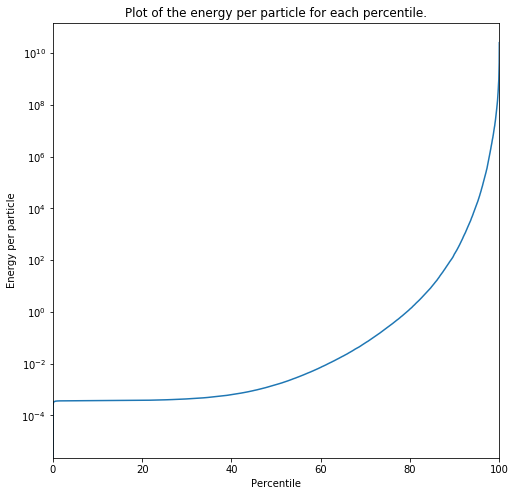

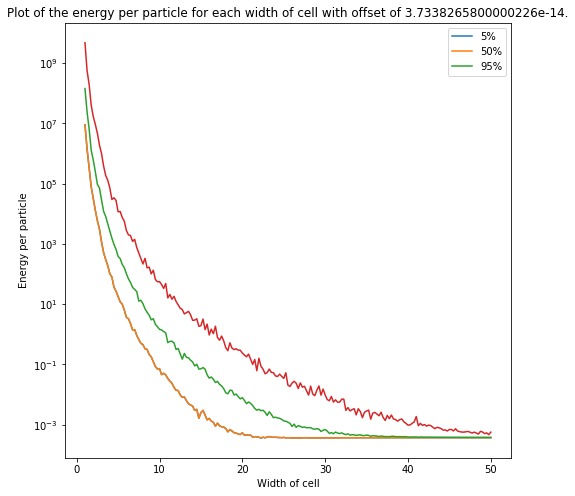

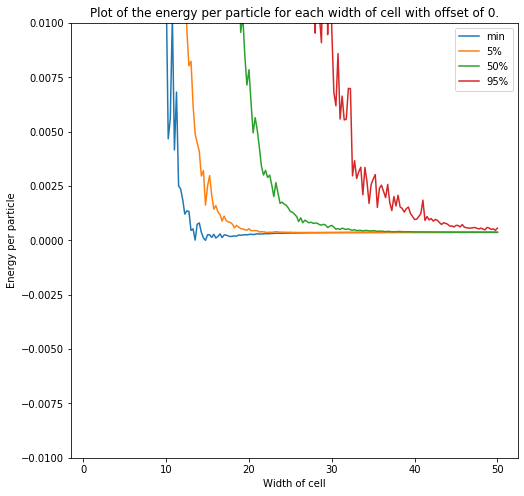

In [278]:
print('Offset is', offset)
data['potentialEnergy'] = data['potentialEnergy']-offset
#qLow = data['potentialEnergy'].quantile(0.00001)
#qHi  = data['potentialEnergy'].quantile(0.90)
dataFiltered = data
#dataFiltered = data[(data['potentialEnergy'] < qHi)]# & (data['potentialEnergy'] > qLow)]

x = dataFiltered['potentialEnergy']
fig, ax = plt.subplots(figsize=(8, 8))
sortedX = np.sort(x) - 1.01 * min(x)
ax.plot([100*i/len(x) for i in range(0, len(x))], sortedX)
ax.set_xlim(0, 100)
ax.set_yscale('log')
ax.set_title('Plot of the energy per particle for each percentile.')
ax.set_ylabel('Energy per particle')
ax.set_xlabel('Percentile')
plt.show()


#"""
tempData = dataFiltered
tempOfsett = 1.01 * min(tempData['potentialEnergy'])
tempData['potentialEnergy'] = tempData['potentialEnergy'] - tempOfsett
medianData = tempData.groupby('widthOfCell').describe(percentiles=[0.05, 0.5, 0.95])
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(medianData.index, medianData['potentialEnergy']['5%'])
ax.plot(medianData.index, medianData['potentialEnergy']['5%'])
ax.plot(medianData.index, medianData['potentialEnergy']['50%'])
ax.plot(medianData.index, medianData['potentialEnergy']['95%'])
plt.legend(['5%', '50%', '95%'])
ax.set_yscale('log')
ax.set_title('Plot of the energy per particle for each width of cell with offset of ' + str(tempOfsett) + '.')
ax.set_ylabel('Energy per particle')
ax.set_xlabel('Width of cell')
plt.show()
#"""

#"""
tempData = dataFiltered
tempOfsett = 0#1.01 * min(tempData['potentialEnergy'])
tempData['potentialEnergy'] = tempData['potentialEnergy'] - tempOfsett
medianData = tempData.groupby('widthOfCell').describe(percentiles=[0.05, 0.5, 0.95])
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(medianData.index, medianData['potentialEnergy']['min'])
ax.plot(medianData.index, medianData['potentialEnergy']['5%'])
ax.plot(medianData.index, medianData['potentialEnergy']['50%'])
ax.plot(medianData.index, medianData['potentialEnergy']['95%'])
plt.legend(['min', '5%', '50%', '95%'])
plt.ylim(-10**-2, 10**-2)
ax.set_title('Plot of the energy per particle for each width of cell with offset of ' + str(tempOfsett) + '.')
ax.set_ylabel('Energy per particle')
ax.set_xlabel('Width of cell')
plt.show()
#"""


data = dataFiltered

In [ ]:
#data.head()

In [ ]:
data.describe()

In [246]:
trainingData = data.sample(frac=0.8)
validationData = data.drop(trainingData.index)

inputData = []
targetData = []
for i in trainingData.index:
    inputData.append(trainingData['eigenvalues'][i])#TODO remove sorted once fixed in data
    targetData.append(trainingData['potentialEnergy'][i])

trainingInput = [[inputData], [targetData]]

inputData = []
targetData = []
for i in validationData.index:
    inputData.append(validationData['eigenvalues'][i])#TODO remove sorted once fixed in data
    targetData.append(validationData['potentialEnergy'][i])

validationInput = [[inputData], [targetData]]

## Preparing testing

No handles with labels found to put in legend.


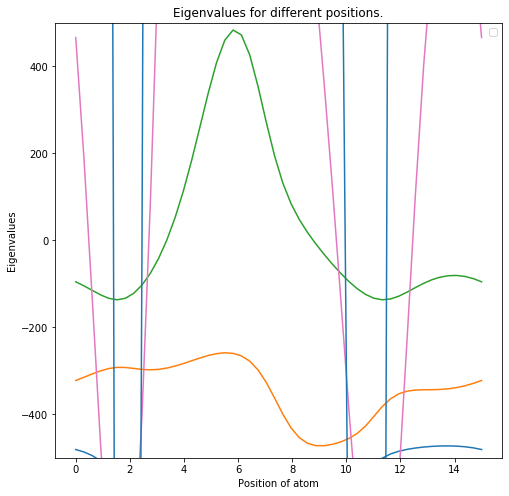

,index,widthOfCell,numberOfSurroundingCells,potentialEnergy
count,50.00000,50.0,50.0,50.000000
mean,24.50000,15.0,4.0,2.429587
std,14.57738,0.0,0.0,5.956234
min,0.00000,15.0,4.0,0.002212
25%,12.25000,15.0,4.0,0.002786
50%,24.50000,15.0,4.0,0.015709
75%,36.75000,15.0,4.0,0.517354
max,49.00000,15.0,4.0,24.436297


In [247]:
#"""
widthOfCell = 15.0
numberOfSurroundingCells = 4
R0 = 100
x = np.linspace(0, 1, 50)

testData = {'particleCoordinates': [],'widthOfCell':[] , 'numberOfSurroundingCells': [], 'potentialEnergy':[]}# Initialy use a dictionary because it's easier to append to than a dataframe.
for i in x:
    particles = [np.array([0.3, 0.5]), np.array([0.9, 0.9]), np.array([0.6, 0.4]), np.array([0.5, i])]
    #particles = [np.array([0.3, 0.5]), np.array([0.3, 0.4]), np.array([0.6, 0.4]), np.array([0.5, i])]
    particles = [widthOfCell * coordinate for coordinate in particles]
    otherSpace = generateSpace(particles, numberOfSurroundingCells, widthOfCell)# Generate the other space.
    testData['particleCoordinates'].append(particles)
    testData['widthOfCell'].append(widthOfCell)
    testData['numberOfSurroundingCells'].append(numberOfSurroundingCells)
    testData['potentialEnergy'].append(potentialEnergy(otherSpace, particles, potentialEnergyPerTrio) - offset)# Calculate the potential energy and save it to the data dictonairy.

x = widthOfCell * x
testData = prepareDatabseForMachineLearning(pd.DataFrame(testData), orderOfMatrix, R0, giveUpdates = False)

#for i in range(len(x)):
#    print(testData['eigenvalues'][i])

fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), [testData['eigenvalues'][i] for i in range(len(testData['eigenvalues']))])
ax1.legend()
ax1.set_ylim(-500, 500)
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Eigenvalues')
ax1.set_title('Eigenvalues for different positions.')
plt.show()

testData.head()
testData.describe()
#"""

# Machine learning

In [248]:
models = []

## Model 0: Linear only

In [249]:
settings = [['Dense', 1, 'linear', False]]
learningRate = 1*10**-3

model = makeNetwork(inputSize, settings, learningRate, 'he_uniform')#eras.initializers.glorot_uniform(seed=None)
model.summary()

for i in range(len(model.layers)):
    print('Layer ' + str(i) + ': ', model.layers[i].get_weights())

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 1)                 12        
_________________________________________________________________
activation_41 (Activation)   (None, 1)                 0         
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________
Layer 0:  [array([[ 0.10207075],
       [ 0.33605045],
       [-0.59112436],
       [ 0.4174177 ],
       [ 0.21387047],
       [ 0.3819391 ],
       [ 0.5255979 ],
       [-0.5283443 ],
       [ 0.15317595],
       [-0.46784738],
       [-0.05311936],
       [-0.24170408]], dtype=float32)]
Layer 1:  []


Train on 50835 samples, validate on 21787 samples
Epoch 1/30
50835/50835 [==============================] - 10s 198us/step - loss: 83586.8243 - val_loss: 6565.8056
Epoch 2/30
50835/50835 [==============================] - 18s 350us/step - loss: 5644.2592 - val_loss: 5974.6361
Epoch 3/30
50835/50835 [==============================] - 12s 240us/step - loss: 3976.7412 - val_loss: 3904.7210
Epoch 4/30
50835/50835 [==============================] - 7s 145us/step - loss: 2800.5097 - val_loss: 3922.0847
Epoch 5/30
50835/50835 [==============================] - 8s 153us/step - loss: 1938.7447 - val_loss: 2894.1286
Epoch 6/30
50835/50835 [==============================] - 7s 146us/step - loss: 1480.4902 - val_loss: 1730.0741
Epoch 7/30
50835/50835 [==============================] - 12s 238us/step - loss: 1462.0493 - val_loss: 1044.6196
Epoch 8/30
50835/50835 [==============================] - 8s 166us/step - loss: 1252.2034 - val_loss: 641.4473
Epoch 9/30
50835/50835 [==========================

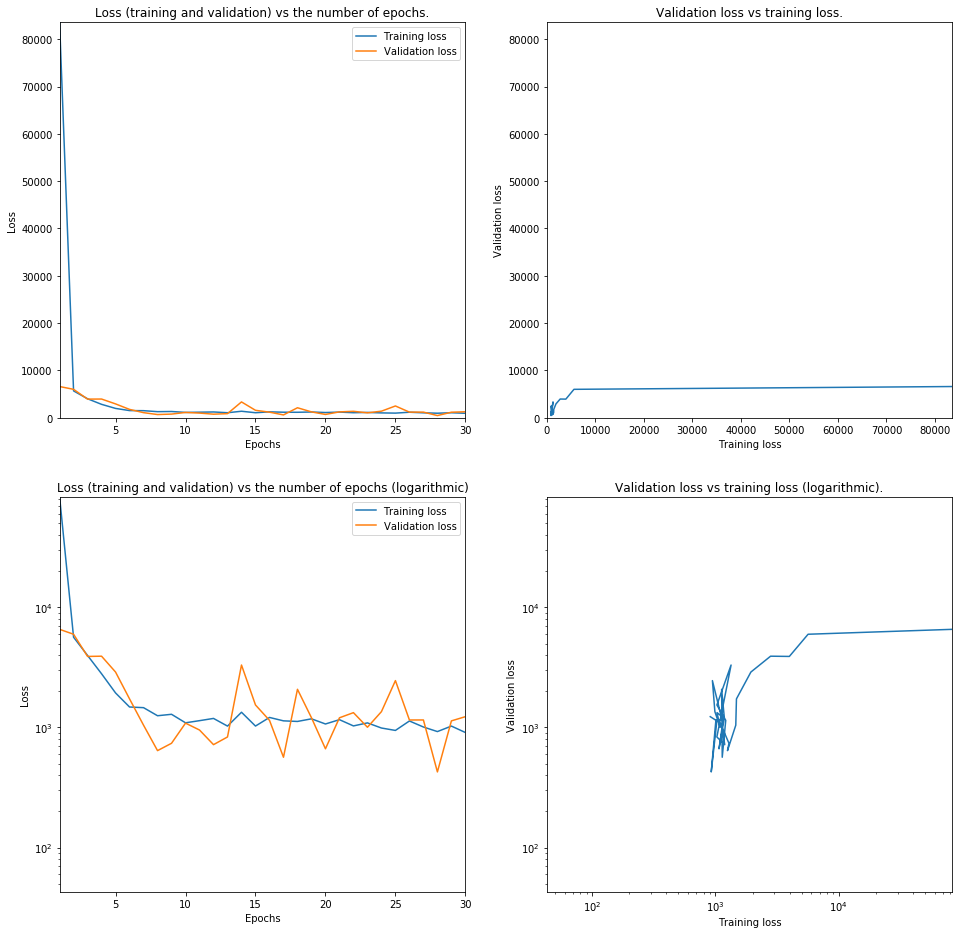


Layer 0:  [array([[ 0.26723573],
       [ 0.11256573],
       [ 1.100119  ],
       [ 0.24087383],
       [ 0.05524543],
       [ 0.13568796],
       [ 0.07372854],
       [ 0.04510974],
       [-0.0040949 ],
       [-0.00660629],
       [-0.00758213],
       [-0.00443659]], dtype=float32)]
Layer 1:  []


In [250]:
trainNetwork(model, trainingInput, 0.3, numberOfEpochs=30, batchSize=32, verboseSetting=1)
models.append([model, 'model0'])
print()

for i in range(len(model.layers)):
    print('Layer ' + str(i) + ': ', model.layers[i].get_weights())

18155/18155 [==============================] - 1s 48us/step
1204.7530567570516


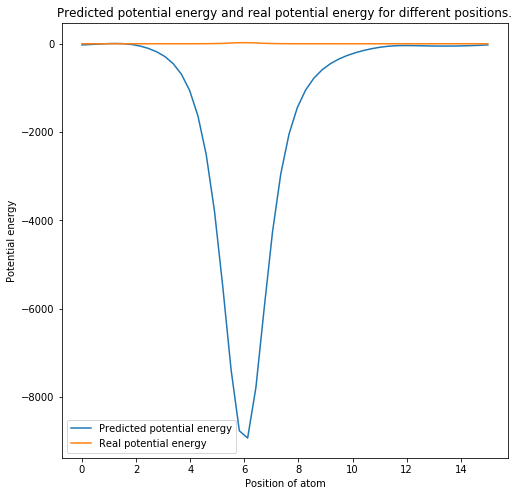

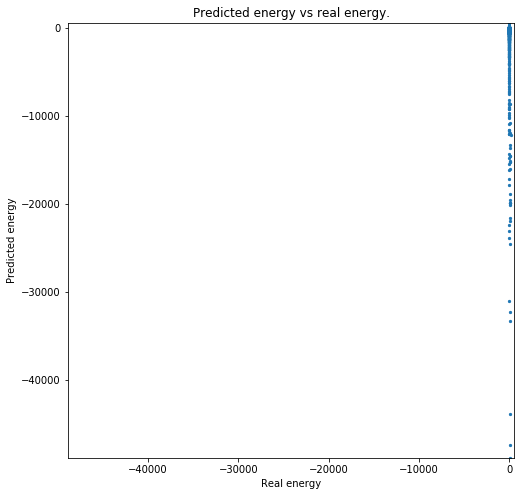

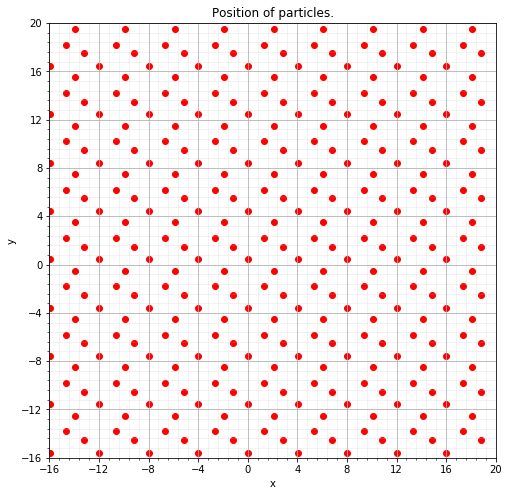

For index 395 Predicted -11916.172 was 66.604641690658


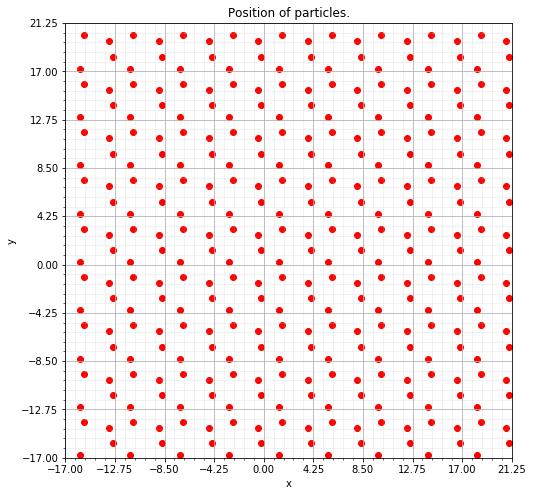

For index 443 Predicted -43952.5 was 138.447136823058


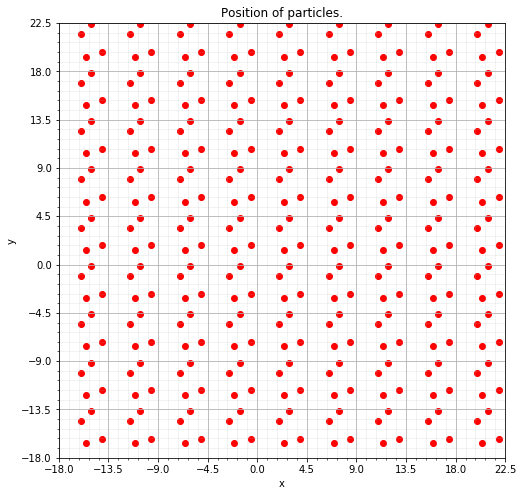

For index 476 Predicted -32327.844 was 123.474648200358


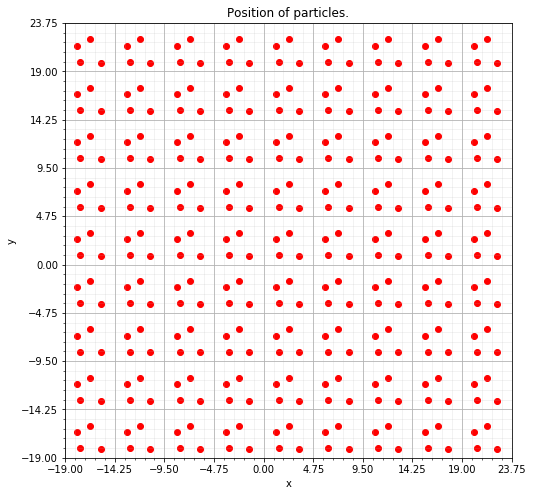

For index 491 Predicted -19948.094 was 66.686136934858


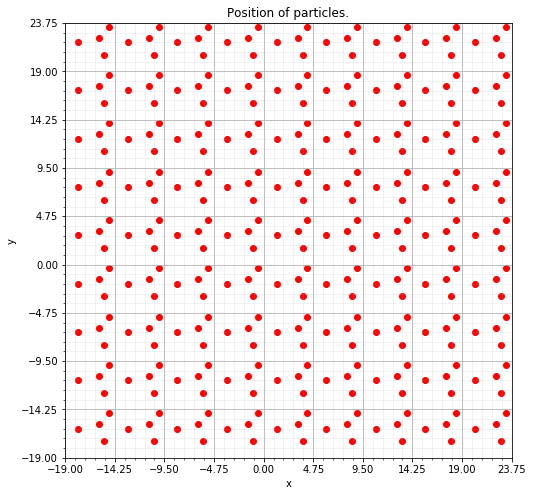

For index 506 Predicted -8646.344 was 50.150184559357996


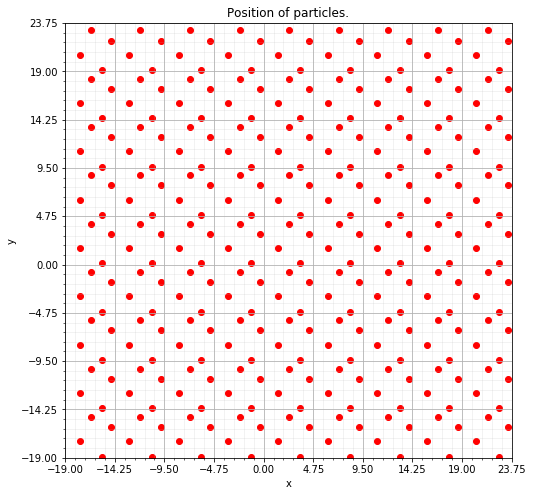

For index 509 Predicted -20103.906 was 79.855799156858


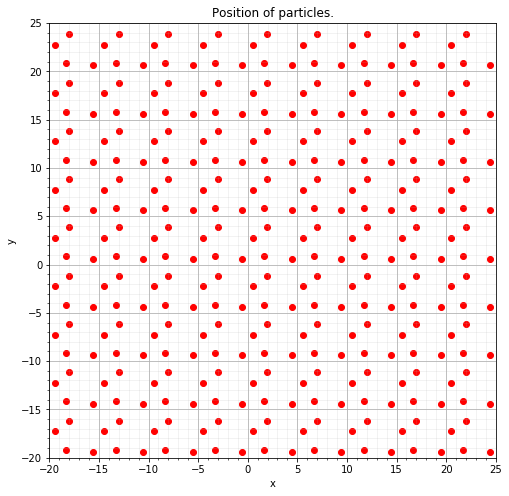

For index 518 Predicted -2465.9375 was 12.197586193658


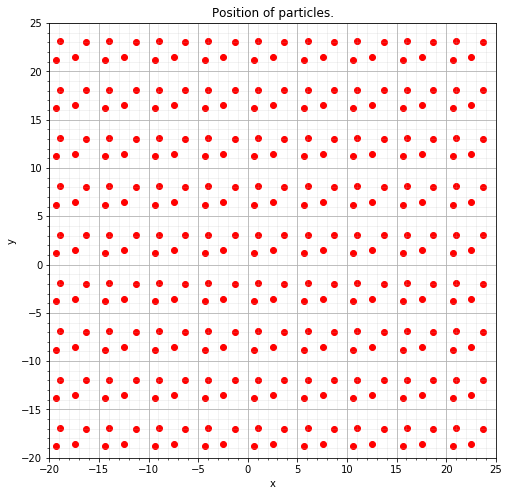

For index 529 Predicted -147.96094 was 12.178917362658


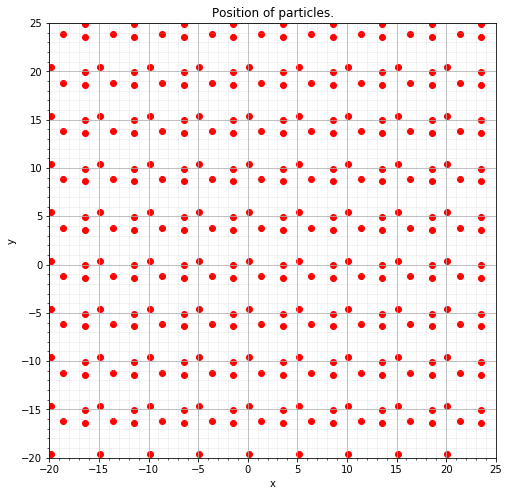

For index 535 Predicted -19877.875 was 86.582810374958


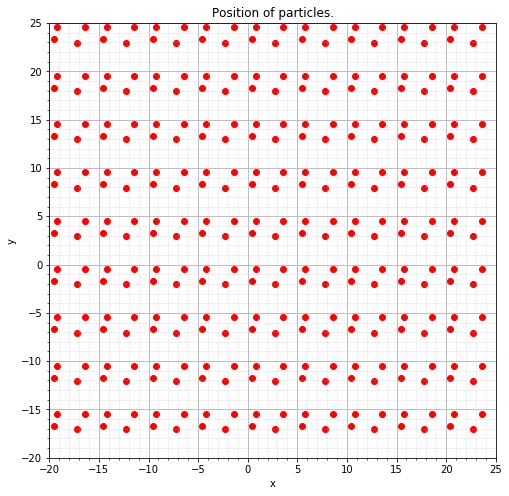

For index 542 Predicted -33349.75 was 93.083545774758
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 1)                 12        
_________________________________________________________________
activation_41 (Activation)   (None, 1)                 0         
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________
None
[array([[ 0.26723573],
       [ 0.11256573],
       [ 1.100119  ],
       [ 0.24087383],
       [ 0.05524543],
       [ 0.13568796],
       [ 0.07372854],
       [ 0.04510974],
       [-0.0040949 ],
       [-0.00660629],
       [-0.00758213],
       [-0.00443659]], dtype=float32)]
[]



In [251]:
#model = models[0][0]
print(model.evaluate(validationInput[0], validationInput[1]))

y = [[],[]]
for i in range(len(x)):
    y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
#ax1.set_ylim(-0.75 * offset , 1.5 * max(y[1]))
plt.show()

makePredictionPlot(model, validationData)

for i in range(0,10):
    plotAndPredict(model, validationData, validationData.index[i])

#"""
print(model.summary())
for layer in model.layers:
    print(layer.get_weights())
#"""
print()

## Model 1: 1024 wide, 1 layer

In [252]:
settings = [['Dense', 1024, 'softplus', False], ['Dense', 1, 'linear', False]]
learningRate = 1*10**-3

model = makeNetwork(inputSize, settings, learningRate, 'he_uniform')#keras.initializers.glorot_uniform(seed=None)
model.summary()

for i in range(len(model.layers)):
    print('Layer ' + str(i) + ': ', model.layers[i].get_weights())

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 1024)              12288     
_________________________________________________________________
activation_42 (Activation)   (None, 1024)              0         
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 1024      
_________________________________________________________________
activation_43 (Activation)   (None, 1)                 0         
Total params: 13,312
Trainable params: 13,312
Non-trainable params: 0
_________________________________________________________________
Layer 0:  [array([[-0.51224303,  0.2768222 ,  0.07582301, ...,  0.34408098,
         0.42819303,  0.05816549],
       [ 0.07584208, -0.4985387 , -0.65839094, ..., -0.32734412,
        -0.6176806 , -0.6445455 ],
       [ 0.05003035,  0.4779833 ,  0

In [253]:
trainNetwork(model, trainingInput, 0.3, numberOfEpochs=100, batchSize=32, verboseSetting=1)
models.append([model, 'model1'])
print()

Train on 50835 samples, validate on 21787 samples
Epoch 1/100
50835/50835 [==============================] - 7s 130us/step - loss: 140413.5102 - val_loss: 161032.7843
Epoch 2/100
50835/50835 [==============================] - 7s 130us/step - loss: 114100.7208 - val_loss: 47310.0028
Epoch 3/100
50835/50835 [==============================] - 7s 146us/step - loss: 114295.6006 - val_loss: 85759.7518
Epoch 4/100
50835/50835 [==============================] - 7s 131us/step - loss: 94539.9442 - val_loss: 89171.2734
Epoch 5/100
50835/50835 [==============================] - 7s 138us/step - loss: 106008.4968 - val_loss: 201387.8467
Epoch 6/100
50835/50835 [==============================] - 8s 152us/step - loss: 100237.4238 - val_loss: 42283.8853
Epoch 7/100
50835/50835 [==============================] - 7s 143us/step - loss: 81200.2000 - val_loss: 18992.2587
Epoch 8/100
50835/50835 [==============================] - 7s 131us/step - loss: 70860.4101 - val_loss: 31945.6382
Epoch 9/100
50835/50835

50835/50835 [==============================] - 7s 130us/step - loss: 3.3072 - val_loss: 3.5771
Epoch 73/100
50835/50835 [==============================] - 7s 131us/step - loss: 3.3072 - val_loss: 3.5771
Epoch 74/100
50835/50835 [==============================] - 7s 145us/step - loss: 3.3072 - val_loss: 3.5771
Epoch 75/100
50835/50835 [==============================] - 7s 128us/step - loss: 3.3072 - val_loss: 3.5771
Epoch 76/100
50835/50835 [==============================] - 8s 160us/step - loss: 3.3072 - val_loss: 3.5771
Epoch 77/100
50835/50835 [==============================] - 7s 142us/step - loss: 3.3072 - val_loss: 3.5771
Epoch 78/100
50835/50835 [==============================] - 8s 156us/step - loss: 3.3072 - val_loss: 3.5771
Epoch 79/100
50835/50835 [==============================] - 8s 156us/step - loss: 3.3072 - val_loss: 3.5771
Epoch 80/100
50835/50835 [==============================] - 7s 146us/step - loss: 3.3073 - val_loss: 3.5771
Epoch 81/100
50835/50835 [===============

KeyboardInterrupt: 

In [ ]:
#model = models[1][0]
print(model.evaluate(validationInput[0], validationInput[1]))

y = [[],[]]
for i in range(len(x)):
    y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
#ax1.set_ylim(-0.75 * offset , 1.5 * max(y[1]))
plt.show()

makePredictionPlot(model, validationData)

for i in range(0,10):
    plotAndPredict(model, validationData, validationData.index[i])

#"""
print(model.summary())
for layer in model.layers:
    print(layer.get_weights())
#"""
print()


# ijgrhm;grgr
# iohjrthiokljnniklthttrh
# Esifgreiogrienrne
# nrgklngekmgre
# ijgrhm;grgr
# iohjrthiokljnniklthttrh
# Esifgreiogrienrne
# nrgklngekmgre
# ijgrhm;grgr
# iohjrthiokljnniklthttrh
# Esifgreiogrienrne
# nrgklngekmgre
# ijgrhm;grgr
# iohjrthiokljnniklthttrh
# Esifgreiogrienrne
# nrgklngekmgre
## Model 2: 2048 wide, 1 layer

In [210]:
settings = [['Dense', 2048, 'softplus', False], ['Dense', 1, 'linear', False]]
learningRate = 5*10**-4

model = makeNetwork(inputSize, settings, learningRate, 'he_uniform')
model.summary()

for i in range(len(model.layers)):
    print('Layer ' + str(i) + ': ', model.layers[i].get_weights())

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 2048)              24576     
_________________________________________________________________
activation_34 (Activation)   (None, 2048)              0         
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 2048      
_________________________________________________________________
activation_35 (Activation)   (None, 1)                 0         
Total params: 26,624
Trainable params: 26,624
Non-trainable params: 0
_________________________________________________________________


Train on 50835 samples, validate on 21787 samples
Epoch 1/30
50835/50835 [==============================] - 13s 256us/step - loss: 103701.0029 - val_loss: 100688.0197
Epoch 2/30
50835/50835 [==============================] - 6s 111us/step - loss: 95907.6945 - val_loss: 51719.5860
Epoch 3/30
50835/50835 [==============================] - 5s 107us/step - loss: 103366.9816 - val_loss: 115741.5013
Epoch 4/30
50835/50835 [==============================] - 5s 101us/step - loss: 112248.0970 - val_loss: 13121.0506
Epoch 5/30
50835/50835 [==============================] - 5s 105us/step - loss: 79872.4774 - val_loss: 7938.7178
Epoch 6/30
50835/50835 [==============================] - 5s 101us/step - loss: 100992.2242 - val_loss: 173815.2152
Epoch 7/30
50835/50835 [==============================] - 5s 102us/step - loss: 107722.8650 - val_loss: 99423.3756
Epoch 8/30
50835/50835 [==============================] - 5s 100us/step - loss: 91381.6823 - val_loss: 16742.3794
Epoch 9/30
50835/50835 [======

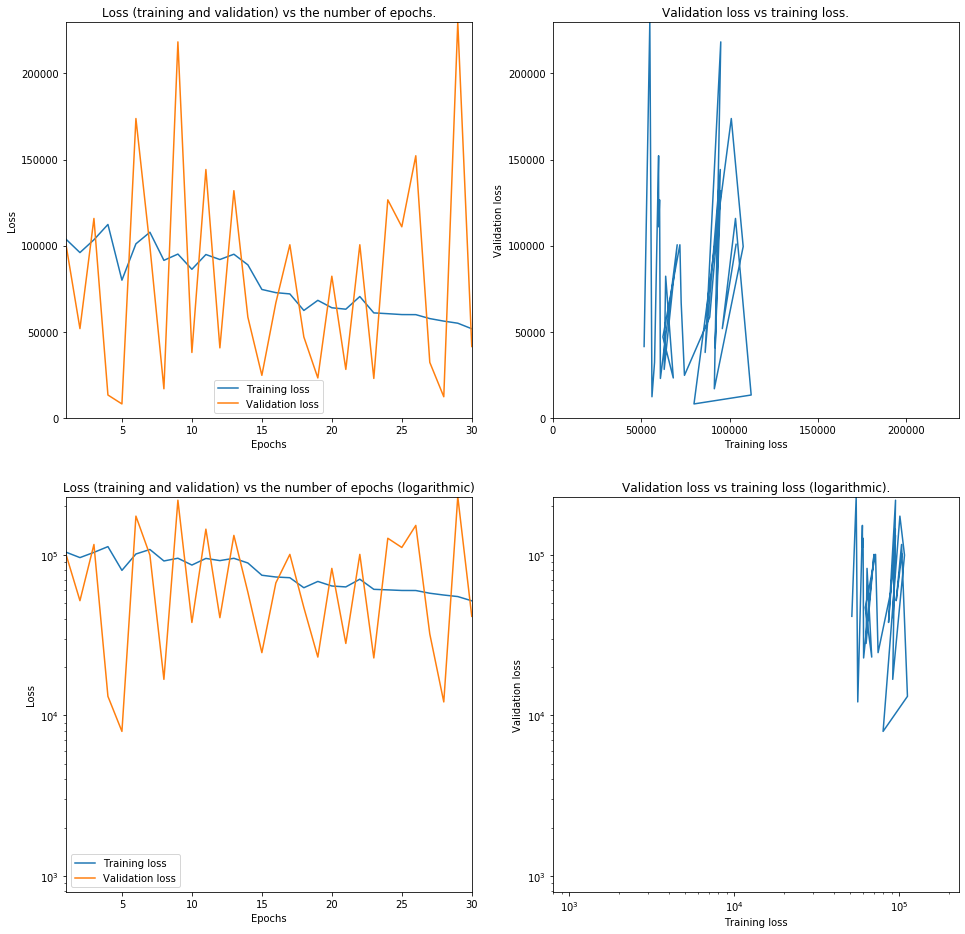

In [211]:
trainNetwork(model, trainingInput, 0.3, numberOfEpochs=30, batchSize=32, verboseSetting=1)
models.append([model, 'model2'])
print()

18155/18155 [==============================] - 1s 61us/step
39512.802227526015


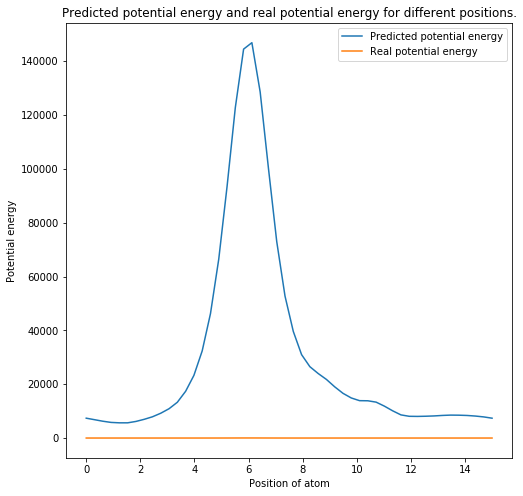

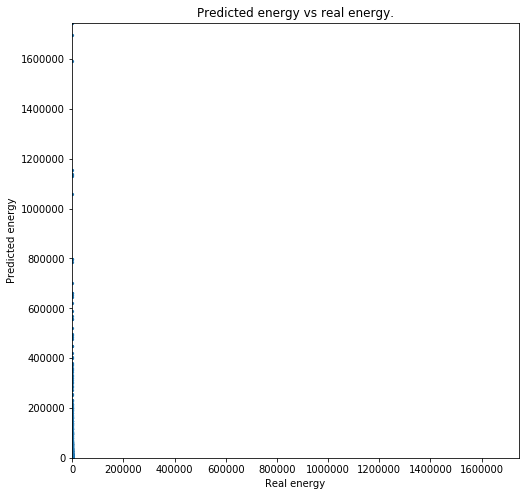

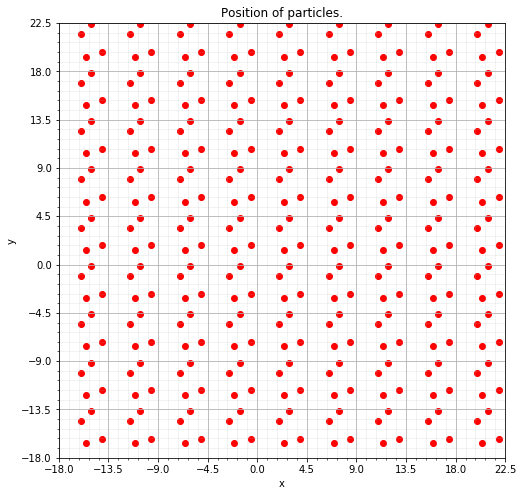

For index 476 Predicted 1695519.5 was 123.474648200358


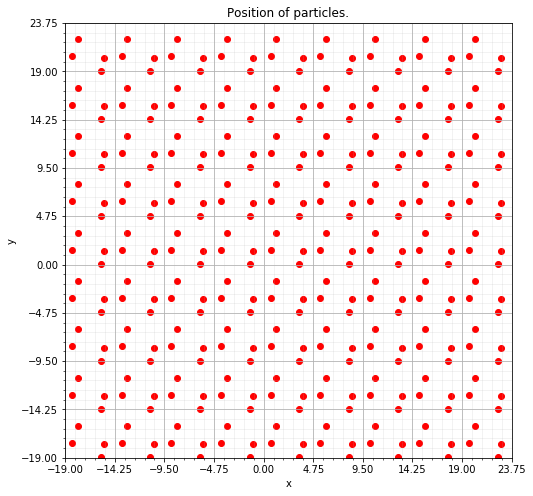

For index 483 Predicted 1154653.0 was 82.464328809658


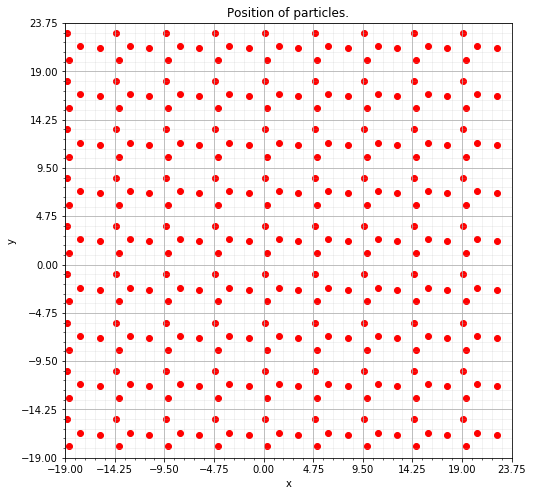

For index 495 Predicted 212403.0 was 22.479063365658


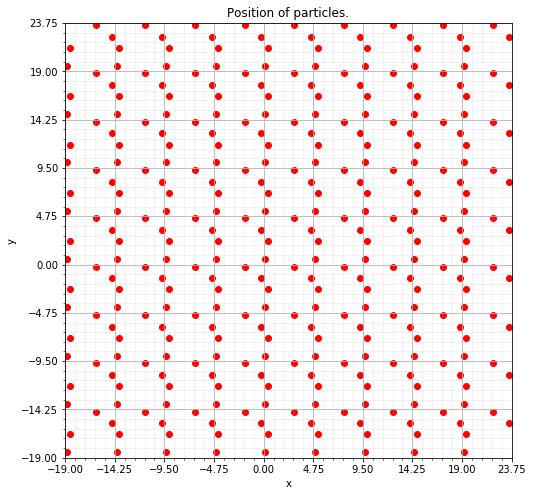

For index 501 Predicted 796455.5 was 144.621055983058


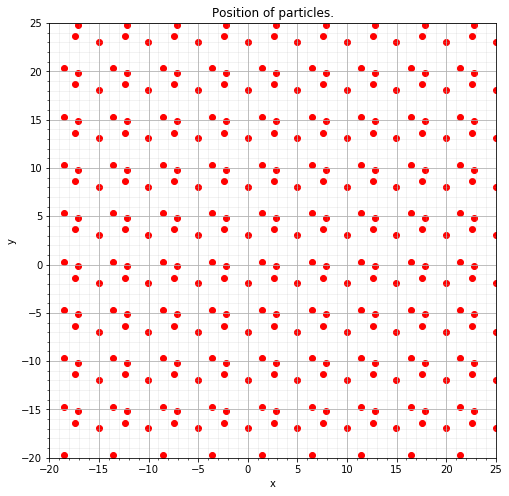

For index 515 Predicted 701492.5 was 170.99799303755802


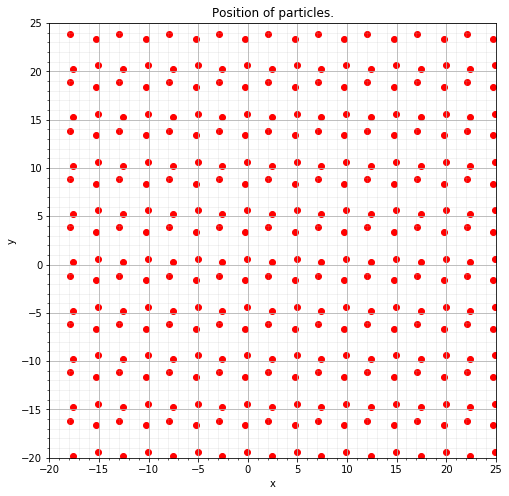

For index 534 Predicted 645672.25 was 53.290376538358


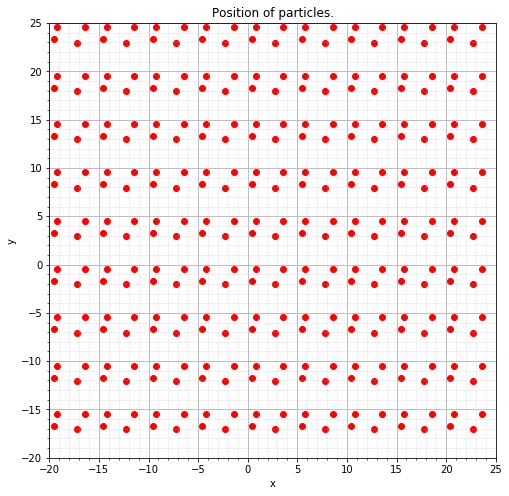

For index 542 Predicted 1134660.5 was 93.083545774758


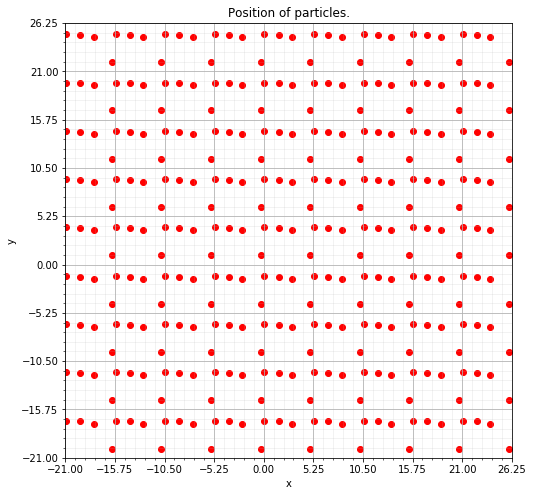

For index 552 Predicted 622238.0 was 60.814966618957996


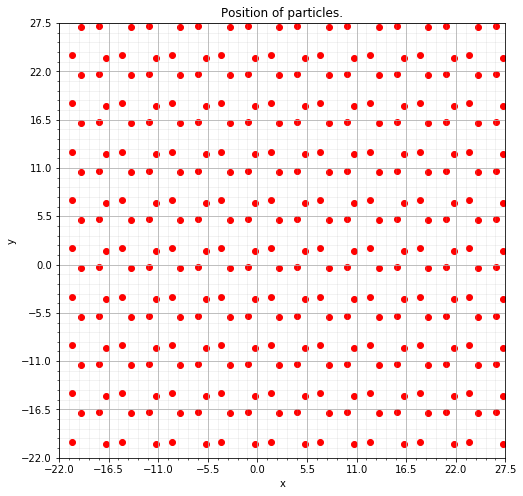

For index 586 Predicted 498605.75 was 16.352581797558003


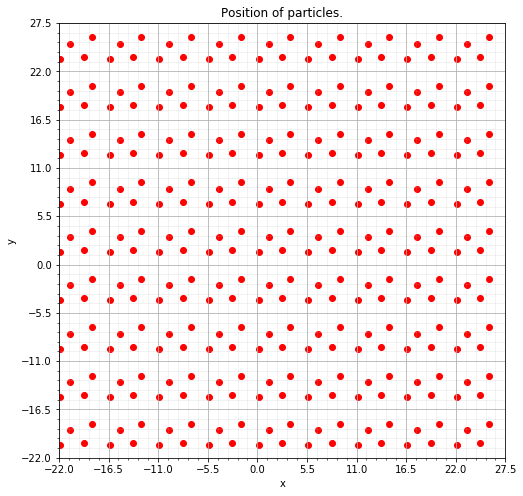

For index 591 Predicted 350924.5 was 5.347625842258



In [212]:
#model = models[2][0]
print(model.evaluate(validationInput[0], validationInput[1]))

y = [[],[]]
for i in range(len(x)):
    y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
#ax1.set_ylim(-0.75 * offset , 1.5 * max(y[1]))
plt.show()

makePredictionPlot(model, validationData)

for i in range(0,10):
    plotAndPredict(model, validationData, validationData.index[i])

"""
print(model.summary())
for layer in model.layers:
    print(layer.get_weights())
#"""
print()

## Model 3: 4096 wide, 1 layer

In [ ]:
settings = [['Dense', 4096, 'softplus', False], ['Dense', 1, 'linear', False]]
learningRate = 5*10**-4

model = makeNetwork(inputSize, settings, learningRate)
model.summary()

In [ ]:
trainNetwork(model, trainingInput, 0.3, numberOfEpochs=30, batchSize=32, verboseSetting=1)
models.append([model, 'model3'])
print()

In [ ]:
#model = models[3][0]
print(model.evaluate(validationInput[0], validationInput[1]))

y = [[],[]]
for i in range(len(x)):
    y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
#ax1.set_ylim(-0.75 * offset , 1.5 * max(y[1]))
plt.show()

for i in range(0,10):
    plotAndPredict(model, validationData, validationData.index[i])

"""
print(model.summary())
for layer in model.layers:
    print(layer.get_weights())
#"""
print()

## Model 4: 8192 wide, 1 layer

In [ ]:
settings = [['Dense', 8192, 'softplus', False], ['Dense', 1, 'linear', False]]
learningRate = 5*10**-4

model = makeNetwork(inputSize, settings, learningRate)
model.summary()

In [ ]:
trainNetwork(model, trainingInput, 0.3, numberOfEpochs=30, batchSize=32, verboseSetting=1)
models.append([model, 'model4'])
print()

In [ ]:
#model = models[4][0]
print(model.evaluate(validationInput[0], validationInput[1]))

y = [[],[]]
for i in range(len(x)):
    y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
#ax1.set_ylim(-0.75 * offset , 1.5 * max(y[1]))
plt.show()

makePredictionPlot(model, validationData)

for i in range(0,10):
    plotAndPredict(model, validationData, validationData.index[i])

"""
print(model.summary())
for layer in model.layers:
    print(layer.get_weights())
#"""
print()

## Model 5: 16384 wide, 1 layer

In [ ]:
settings = [['Dense', 16384, 'softplus', False], ['Dense', 1, 'linear', False]]
learningRate = 5*10**-4

model = makeNetwork(inputSize, settings, learningRate)
model.summary()

In [ ]:
trainNetwork(model, trainingInput, 0.3, numberOfEpochs=30, batchSize=32, verboseSetting=1)
models.append([model, 'model5'])
print()

In [ ]:
#model = models[5][0]
print(model.evaluate(validationInput[0], validationInput[1]))

y = [[],[]]
for i in range(len(x)):
    y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
#ax1.set_ylim(-0.75 * offset , 1.5 * max(y[1]))
plt.show()

makePredictionPlot(model, validationData)

for i in range(0,10):
    plotAndPredict(model, validationData, validationData.index[i])

"""
print(model.summary())
for layer in model.layers:
    print(layer.get_weights())
#"""
print()

## Model 6: 1024 wide, 2 layer

In [ ]:
settings = [['Dense', 1024, 'softplus', False], ['Dense', 1024, 'softplus', False], ['Dense', 1, 'linear', False]]
learningRate = 5*10**-4

model = makeNetwork(inputSize, settings, learningRate)
model.summary()

In [ ]:
trainNetwork(model, trainingInput, 0.3, numberOfEpochs=30, batchSize=32, verboseSetting=1)
models.append([model, 'model6'])
print()

In [ ]:
#model = models[6][0]
print(model.evaluate(validationInput[0], validationInput[1]))

y = [[],[]]
for i in range(len(x)):
    y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
#ax1.set_ylim(-0.75 * offset , 1.5 * max(y[1]))
plt.show()

makePredictionPlot(model, validationData)

for i in range(0,10):
    plotAndPredict(model, validationData, validationData.index[i])

"""
print(model.summary())
for layer in model.layers:
    print(layer.get_weights())
#"""
print()

## Model 7: 2048 wide, 2 layers

In [ ]:
settings = [['Dense', 2048, 'softplus', False], ['Dense', 2048, 'softplus', False], ['Dense', 1, 'linear', False]]
learningRate = 5*10**-4

model = makeNetwork(inputSize, settings, learningRate)
model.summary()

In [ ]:
trainNetwork(model, trainingInput, 0.3, numberOfEpochs=30, batchSize=32, verboseSetting=1)
models.append([model, 'model7'])
print()

In [ ]:
#model = models[7][0]
print(model.evaluate(validationInput[0], validationInput[1]))

y = [[],[]]
for i in range(len(x)):
    y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
#ax1.set_ylim(-0.75 * offset , 1.5 * max(y[1]))
plt.show()

makePredictionPlot(model, validationData)

for i in range(0,10):
    plotAndPredict(model, validationData, validationData.index[i])

"""
print(model.summary())
for layer in model.layers:
    print(layer.get_weights())
#"""
print()

## Model 8: 1024 wide, 3 layers

In [ ]:
settings = [['Dense', 1024, 'softplus', False], ['Dense', 1024, 'softplus', False], ['Dense', 1024, 'softplus', False], ['Dense', 1, 'linear', False]]
learningRate = 5*10**-4

model = makeNetwork(inputSize, settings, learningRate)
model.summary()

In [ ]:
trainNetwork(model, trainingInput, 0.3, numberOfEpochs=30, batchSize=32, verboseSetting=1)
models.append([model, 'model8'])
print()

In [ ]:
#model = models[8][0]
print(model.evaluate(validationInput[0], validationInput[1]))

y = [[],[]]
for i in range(len(x)):
    y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
#ax1.set_ylim(-0.75 * offset , 1.5 * max(y[1]))
plt.show()

makePredictionPlot(model, validationData)

for i in range(0,10):
    plotAndPredict(model, validationData, validationData.index[i])

"""
print(model.summary())
for layer in model.layers:
    print(layer.get_weights())
#"""
print()

## Model 9: 2048 wide, 3 layers

In [ ]:
settings = [['Dense', 2048, 'softplus', False], ['Dense', 2048, 'softplus', False], ['Dense', 2048, 'softplus', False], ['Dense', 1, 'linear', False]]
learningRate = 5*10**-4

model = makeNetwork(inputSize, settings, learningRate)
model.summary()

In [ ]:
trainNetwork(model, trainingInput, 0.3, numberOfEpochs=30, batchSize=32, verboseSetting=1)
models.append([model, 'model9'])
print()

In [ ]:
#model = models[9[0]
print(model.evaluate(validationInput[0], validationInput[1]))

y = [[],[]]
for i in range(len(x)):
    y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
#ax1.set_ylim(-0.75 * offset , 1.5 * max(y[1]))
plt.show()

makePredictionPlot(model, validationData)

for i in range(0,10):
    plotAndPredict(model, validationData, validationData.index[i])

"""
print(model.summary())
for layer in model.layers:
    print(layer.get_weights())
#"""
print()

## Model 10: 1024 wide, 4 layers

In [ ]:
settings = [['Dense', 1024, 'softplus', False], ['Dense', 1024, 'softplus', False], ['Dense', 1024, 'softplus', False], ['Dense', 1024, 'softplus', False], ['Dense', 1, 'linear', False]]
learningRate = 5*10**-4

model = makeNetwork(inputSize, settings, learningRate)
model.summary()

In [ ]:
trainNetwork(model, trainingInput, 0.3, numberOfEpochs=30, batchSize=32, verboseSetting=1)
models.append([model, 'model10'])
print()

In [ ]:
#model = models[10][0]
print(model.evaluate(validationInput[0], validationInput[1]))

y = [[],[]]
for i in range(len(x)):
    y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
#ax1.set_ylim(-0.75 * offset , 1.5 * max(y[1]))
plt.show()

makePredictionPlot(model, validationData)

for i in range(0,10):
    plotAndPredict(model, validationData, validationData.index[i])

"""
print(model.summary())
for layer in model.layers:
    print(layer.get_weights())
#"""
print()

## Model 11: 1024 wide, 5 layers

In [ ]:
settings = [['Dense', 1024, 'softplus', False], ['Dense', 1024, 'softplus', False], ['Dense', 1024, 'softplus', False], ['Dense', 1024, 'softplus', False], ['Dense', 1024, 'softplus', False], ['Dense', 1, 'linear', False]]
learningRate = 5*10**-4

model = makeNetwork(inputSize, settings, learningRate)
model.summary()

In [ ]:
trainNetwork(model, trainingInput, 0.3, numberOfEpochs=30, batchSize=32, verboseSetting=1)
models.append([model, 'model11'])
print()

In [ ]:
#model = models[11][0]
print(model.evaluate(validationInput[0], validationInput[1]))

y = [[],[]]
for i in range(len(x)):
    y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
#ax1.set_ylim(-0.75 * offset , 1.5 * max(y[1]))
plt.show()

makePredictionPlot(model, validationData)

for i in range(0,10):
    plotAndPredict(model, validationData, validationData.index[i])

"""
print(model.summary())
for layer in model.layers:
    print(layer.get_weights())
#"""
print()

## Saving a model

In [ ]:
for i in range(len(models)):
    model = models[i][0]
    print(models[i][1])
    print(model.summary())
    print(model.evaluate(validationInput[0], validationInput[1], verbose=0))
    print('\n \n')

#model = models[1][0]
#model.save('model1.h5')
#model = load_model('model1.h5')